# Hypothesis testing validation

Power analysis for DM, DV, and DC

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time
import string

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [3]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/scmemo')
import estimator, simulate, scmemo, bootstrap, util, hypothesis_test

In [4]:
import sys
sys.path.append('/home/ssm-user/Github/single_cell_eb/')
sys.path.append('/home/ssm-user/Github/single_cell_eb/sceb')
import scdd

### Simulate some data

In [5]:
true_data = simulate.simulate_transcriptomes(10000, 2000, correlated=False)
qs, captured_data = simulate.capture_sampling(true_data, q=0.1, q_sq=0.011)


### Perform real bootstrap

Perform bootstrap for two different sets of genes to test for generalizablilty of the bootstrap approximation.

adata_1 is for fitting, adata_2 is for testing

In [2341]:
imp.reload(estimator)
imp.reload(bootstrap)
imp.reload(scmemo)
imp.reload(util)

adata = sc.AnnData(sp.sparse.csr_matrix(captured_data))
adata.obs['ct'] = np.random.choice(2, adata.shape[0])
# adata.obs['ind'] = np.random.choice(list('aef'), adata.shape[0])

adata_scmemo = adata.copy()
adata_scmemo.X = adata_scmemo.X.astype(np.int64)
scmemo.create_groups(adata_scmemo, label_columns=['ct'], inplace=True)

scmemo.compute_1d_moments(adata_scmemo, inplace=True, filter_genes=True, residual_var=True, use_n_umi=False, filter_mean_thresh=0.2, min_perc_group=.9)

In [2344]:
adata_scmemo.shape

(10000, 1097)

In [1196]:
%%time
num_boot=1000
### Perform real bootstrap
adata_1 = adata_scmemo[adata_scmemo.obs['ct'] == 0][:, :500]
adata_2 = adata_scmemo[adata_scmemo.obs['ct'] == 1][:, 500:1000]
sf_1 = adata_scmemo.uns['scmemo']['size_factor']['sg^0']
sf_2 = adata_scmemo.uns['scmemo']['size_factor']['sg^1']

# mean_diff = np.zeros((num_boot, adata_1.shape[1]))
# var_diff = np.zeros((num_boot, adata_1.shape[1]))
mean_1 = np.zeros((num_boot, adata_1.shape[1]))
mean_2 = np.zeros((num_boot, adata_1.shape[1]))
var_1 = np.zeros((num_boot, adata_1.shape[1]))
var_2 = np.zeros((num_boot, adata_1.shape[1]))

for boot in range(num_boot):
    
    if boot % 200 == 0:
        print(boot)
    boot_idx_1 = np.random.choice(adata_1.shape[0], adata_1.shape[0])
    boot_idx_2 = np.random.choice(adata_2.shape[0], adata_2.shape[0])
    
    mean_1[boot, :], var_1[boot, :] = estimator._poisson_1d(adata_1.X[boot_idx_1], adata_1.shape[0], size_factor=sf_1[boot_idx_1], n_umi=adata_scmemo.uns['scmemo']['n_umi'])
    mean_2[boot, :], var_2[boot, :] = estimator._poisson_1d(adata_2.X[boot_idx_2], adata_2.shape[0], size_factor=sf_2[boot_idx_2], n_umi=adata_scmemo.uns['scmemo']['n_umi'])
    
#     mean_diff[boot, :] = mean_2[boot, :] - mean_1[boot, :]
#     var_diff[boot, :] = var_2[boot, :] - var_1[boot, :]

0
200
400
600
800
CPU times: user 1min 42s, sys: 373 ms, total: 1min 42s
Wall time: 1min 42s


In [1197]:
# mean_pval = 2*(np.minimum((mean_diff > 0).sum(axis=0), 5000- (mean_diff > 0).sum(axis=0))+1)/(5000+1)
# var_pval = 2*(np.minimum((var_diff > 0).sum(axis=0), 5000- (var_diff > 0).sum(axis=0))+1)/(5000+1)

### Approximate bootstrap for the first 500 genes and fit the curve for bootstrap variance

In [1198]:
mat_1 = adata_1.X.tocsc()
mat_2 = adata_2.X.tocsc()

In [2369]:
%%time
# for gene_idx in range(20):
num_gene_to_test = 500
imp.reload(bootstrap)
num_bins = 1
var_var_diff = np.zeros(num_gene_to_test)
var_mean_diff = np.zeros(num_gene_to_test)
# unique_count = np.zeros(num_gene_to_test)
var_var_1 = np.zeros(num_gene_to_test)
var_mean_1 = np.zeros(num_gene_to_test)
unique_count_1 = np.zeros(num_gene_to_test)

var_var_2 = np.zeros(num_gene_to_test)
var_mean_2 = np.zeros(num_gene_to_test)
unique_count_2 = np.zeros(num_gene_to_test)


for gene_idx in range(num_gene_to_test):
    
    if gene_idx % 100 == 0:
        print(gene_idx)
    mean_1_approx, var_1_approx, s1= bootstrap._bootstrap_1d(
        mat_1[:, gene_idx],
        size_factor=sf_1, 
        n_umi=adata_scmemo.uns['scmemo']['n_umi'],
        num_boot=10000,
        dirichlet_approx=True,
        log=False)
    
    var_var_1[gene_idx] = var_1_approx.var()
    var_mean_1[gene_idx] = mean_1_approx.var()
    unique_count_1[gene_idx] = s1

    mean_2_approx, var_2_approx, s2= bootstrap._bootstrap_1d(
        mat_2[:, gene_idx], 
        size_factor=sf_2, 
        n_umi=adata_scmemo.uns['scmemo']['n_umi'],
        num_boot=10000,
        dirichlet_approx=True,
        log=False)
    
    var_var_2[gene_idx] = var_2_approx.var()
    var_mean_2[gene_idx] = mean_2_approx.var()
    unique_count_2[gene_idx] = s2
    real_var_diff = var_2[:, gene_idx]-var_1[:, gene_idx]
    approx_var_diff = var_2_approx-var_1_approx
    
    real_mean_diff = mean_2[:, gene_idx]-mean_1[:, gene_idx]
    approx_mean_diff = mean_2_approx-mean_1_approx
    
    var_mean_diff[gene_idx] = real_mean_diff.var()-approx_mean_diff.var()
    var_var_diff[gene_idx]=real_var_diff.var()-approx_var_diff.var()
#     unique_count[gene_idx]=(s1+s2)/2

0
100
200
300
400
CPU times: user 59.9 s, sys: 29.3 ms, total: 59.9 s
Wall time: 59.9 s


### Small example

In [2190]:
def _precompute_size_factor(expr, sf_df, bins):
	"""
		Precompute the size factor to separate it from the bootstrap.
		This function also serves to find and count unique values.
		
		:sf_df: is already a dictionary with memory already allocated to speed up the calculations.
		It should already include the inverse of size factors and inverse of the squared size factors.
	"""
	
	# Get the expression values into the DataFrame
	if expr.ndim > 1:
		sf_df['expr'] = np.random.random()*expr[:, 0]+np.random.random()*expr[:, 1]
		sf_df['expr1'], sf_df['expr2'] = expr[:, 0], expr[:, 1]
	else:
		sf_df['expr'] = expr
	
	# Create bins for size factors
	if bins == 1:
		sf_df['bin'] = 1
	elif bins == 2:
		sf_df['bin_cutoff'] = sf_df.groupby('expr', sort=True)['size_factor'].transform('mean')
		sf_df['bin'] = sf_df['size_factor'] > sf_df['bin_cutoff']
	else:
		sf_df['bin'] = sf_df.groupby('expr', sort=True)['size_factor'].transform(lambda x: _create_bins(x, bins))
	
	groupby_obj = sf_df.groupby(['expr', 'bin'], sort=True)
	precomputed_sf = groupby_obj[['inv_size_factor', 'inv_size_factor_sq']].mean().dropna()
	
	# Get unique expression values
	if expr.ndim > 1:
		unique_expr = groupby_obj[['expr1', 'expr2']].first().dropna().values
	else:
		unique_expr = precomputed_sf.index.get_level_values(0).values.reshape(-1, 1)
	
	# Get unique counts
	counts = groupby_obj.size().values
					
	return (
		precomputed_sf['inv_size_factor'].values.reshape(-1, 1), 
		precomputed_sf['inv_size_factor_sq'].values.reshape(-1, 1),
		unique_expr,
		counts)

def _create_bins(x, num_bins):
	""" Small helper function to create bins dynamically. """
	
# 	bin_edges = np.quantile(x, np.linspace(0, 1, num_bins))

	if x.shape[0] < 20:
		return 1
	_, bin_edges = np.histogram(x, bins=num_bins)
	
	return np.digitize(x, np.unique(bin_edges))

	return pd.cut(x, bins=num_bins, labels=list(string.ascii_lowercase)[:num_bins])

In [2306]:
data = adata_1.X[:, 6].todense().A1
data = adata_1.X[:, 0].todense().A1

all_sf = sf_1
normalized_data = (data/all_sf)

# Algorithm for figuring out number of bins
unique_counts = np.unique(data).shape[0]
num_bins = min(unique_counts, 20)
print(num_bins)

_, sf_bin_edges = np.histogram(data_sf, bins=num_bins)
binned_stat = stats.binned_statistic(all_sf, all_sf, bins=sf_bin_edges, statistic='median')
approx_sf = binned_stat[0][binned_stat[2]-1]

binned_normalized_data = (data/approx_sf)

8


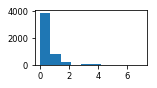

In [2308]:
plt.figure(figsize=(2,1))
plt.hist(data);

In [2309]:
%%time
real_boot_mean_dist = np.array([normalized_data[np.random.choice(data.shape[0], data.shape[0])].mean() for i in range(10000)])
real_boot_var_dist = np.array([normalized_data[np.random.choice(data.shape[0], data.shape[0])].var() for i in range(10000)])

real_binned_boot_mean_dist = np.array([binned_normalized_data[np.random.choice(data.shape[0], data.shape[0])].mean() for i in range(10000)])
real_binned_boot_var_dist = np.array([binned_normalized_data[np.random.choice(data.shape[0], data.shape[0])].var() for i in range(10000)])

CPU times: user 4.05 s, sys: 51.9 ms, total: 4.1 s
Wall time: 4.03 s


In [2310]:
%%time
# Approximation #1
sf_df = pd.DataFrame()
sf_df['expr'] = data
sf_df['size_factor'] = all_sf
sf_df['inv_size_factor'] = 1/data_df['sf']
sf_df['inv_size_factor_sq'] = 1/data_df['sf']**2
sf_df['bin'] = 1

inv_sf, inv_sf_sq, expr, counts = _precompute_size_factor(
    expr=data, 
    sf_df=sf_df,
    bins=unique_counts)
# precomputed_sf = data_df.groupby('expr')['inv_sf', 'inv_sf_sq'].mean()
# expr, count = np.unique(data, return_counts=True)


mult_rvs = stats.multinomial.rvs(n=data.shape[0], p=counts/data.shape[0], size=10000).T

approx_boot_mean_dist = (expr.reshape(-1, 1) * mult_rvs * inv_sf).sum(axis=0)/data.shape[0]
approx_boot_var_dist = (expr.reshape(-1, 1)**2 * mult_rvs * inv_sf_sq).sum(axis=0)/data.shape[0] - approx_boot_mean_dist**2

CPU times: user 72.2 ms, sys: 0 ns, total: 72.2 ms
Wall time: 71.1 ms


In [2311]:
%%time
# Approximation #2
expr_sf_data = np.vstack([data, approx_sf]).T
expr_sf, index, count = np.unique(expr_sf_data, return_index=True, return_counts=True, axis=0)
expr, sf = expr_sf[:, 0], expr_sf[:, 1]
inv_sf = 1/sf.reshape(-1, 1)#inv_approx_sf[index].reshape(-1, 1)
inv_sf_sq = 1/sf.reshape(-1, 1)**2#inv_approx_sf_sq[index].reshape(-1, 1)

mult_rvs = stats.multinomial.rvs(n=data.shape[0], p=count/data.shape[0], size=10000).T
approx_boot_mean_dist = (expr.reshape(-1, 1) * mult_rvs * inv_sf).sum(axis=0)/data.shape[0]
approx_boot_var_dist = (expr.reshape(-1, 1)**2 * mult_rvs * inv_sf_sq).sum(axis=0)/data.shape[0] - approx_boot_mean_dist**2

CPU times: user 55.3 ms, sys: 174 µs, total: 55.5 ms
Wall time: 54.8 ms


In [2312]:
print('width of real boot mean', real_boot_mean_dist.var())
print('width of real binned boot mean', real_binned_boot_mean_dist.var())
print('width of approximated boot mean', approx_boot_mean_dist.var())

print('width of real boot var', real_boot_var_dist.var())
print('width of real binned boot var', real_binned_boot_var_dist.var())
print('width of approximated boot var', approx_boot_var_dist.var())

width of real boot mean 0.00011279673300481197
width of real binned boot mean 0.00011198389817089256
width of approximated boot mean 0.00011464156854742998
width of real boot var 0.0008823097496660311
width of real binned boot var 0.0008454897834030192
width of approximated boot var 0.0008820516579391092


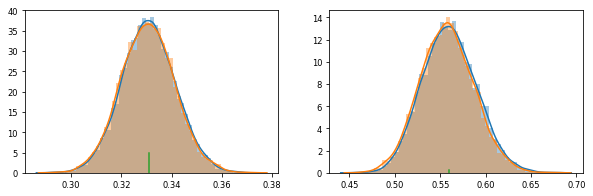

In [2313]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
sns.distplot(real_boot_mean_dist)
# sns.distplot(real_binned_boot_mean_dist)
sns.distplot(approx_boot_mean_dist)
plt.plot([normalized_data.mean(), normalized_data.mean()], [0, 5])

plt.subplot(1, 2, 2)
sns.distplot(real_boot_var_dist)
# sns.distplot(real_binned_boot_var_dist)
sns.distplot(approx_boot_var_dist)

plt.plot([normalized_data.var(), normalized_data.var()], [0, 0.25])


### Simulate some data

In [2464]:
true_data = simulate.simulate_transcriptomes(10000, 5000, correlated=False)
qs, captured_data = simulate.capture_sampling(true_data, q=0.1, q_sq=0.011)


### Perform real bootstrap

Perform bootstrap for two different sets of genes to test for generalizablilty of the bootstrap approximation.

adata_1 is for fitting, adata_2 is for testing

In [2465]:
imp.reload(estimator)
imp.reload(bootstrap)
imp.reload(scmemo)
imp.reload(util)

adata = sc.AnnData(sp.sparse.csr_matrix(captured_data))
adata.obs['ct'] = np.random.choice(2, adata.shape[0])
# adata.obs['ind'] = np.random.choice(list('aef'), adata.shape[0])

adata_scmemo = adata.copy()
adata_scmemo.X = adata_scmemo.X.astype(np.int64)
scmemo.create_groups(adata_scmemo, label_columns=['ct'], inplace=True)

scmemo.compute_1d_moments(adata_scmemo, inplace=True, filter_genes=True, residual_var=True, use_n_umi=False, filter_mean_thresh=0.2, min_perc_group=.9)

In [2466]:
adata_scmemo.shape

(10000, 2831)

In [2467]:
%%time
imp.reload(hypothesis_test)
imp.reload(scmemo)
imp.reload(estimator)
imp.reload(bootstrap)
a = scmemo.ht_1d_moments(
	adata_scmemo, 
	formula_like='1 + ct',
	cov_column='ct',
	inplace=False, 
	use_residual_var=False, 
	num_boot=10000, 
	dirichlet_approx=True,
    log=False)

CPU times: user 25min 32s, sys: 8min 3s, total: 33min 35s
Wall time: 33min 35s


In [2478]:
x = a.uns['scmemo']['1d_ht']['mean_asl']
x = x - np.nanmin(x)
x = x / np.nanmax(x)

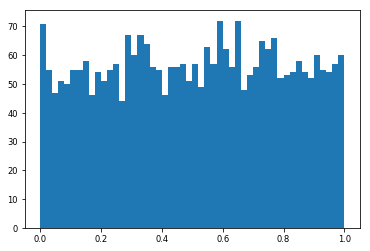

In [2481]:
plt.hist(x, bins=50);

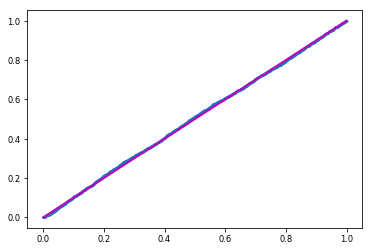

In [2475]:
plt.plot([0, 1], [0, 1], color='m', lw=2)
plt.scatter(
    np.linspace(0, 1, a.uns['scmemo']['1d_ht']['var_asl'].shape[0]), 
    np.sort(x), s=1)


In [2476]:
np.exp(-6)

0.0024787521766663585

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


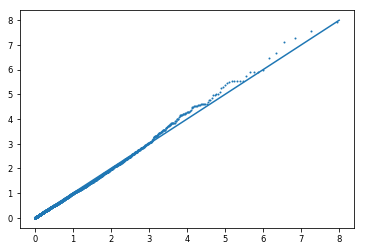

In [2477]:
plt.scatter(
    -np.log(np.linspace(0, 1, a.uns['scmemo']['1d_ht']['var_asl'].shape[0])), 
    -np.log(np.sort(x)), s=1)
plt.plot([0, 8], [0, 8])
# plt.xlim(0,5)
# plt.ylim(0,5)

***

(array([75., 70., 84., 68., 53., 71., 72., 65., 60., 57., 68., 64., 54.,
        64., 75.]),
 array([2.75565601e-05, 6.66520843e-02, 1.33276612e-01, 1.99901140e-01,
        2.66525667e-01, 3.33150195e-01, 3.99774723e-01, 4.66399251e-01,
        5.33023778e-01, 5.99648306e-01, 6.66272834e-01, 7.32897361e-01,
        7.99521889e-01, 8.66146417e-01, 9.32770945e-01, 9.99395472e-01]),
 <a list of 15 Patch objects>)

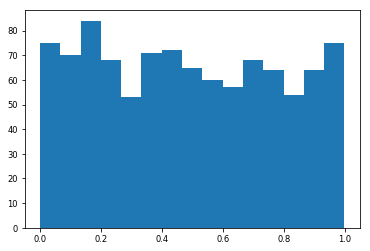

In [330]:
plt.hist(unif, bins=15)

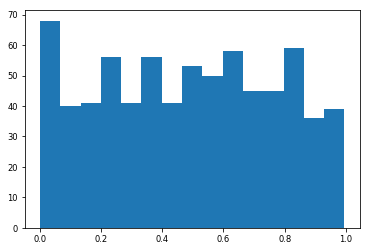

In [327]:
plt.hist(a.uns['scmemo']['1d_ht']['var_asl'], bins=15);

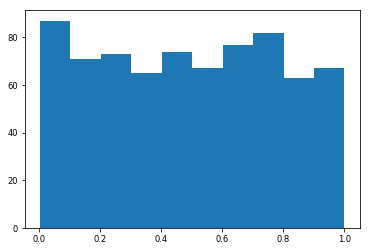

In [243]:
plt.hist(a.uns['scmemo']['1d_ht']['var_asl'], bins=10);

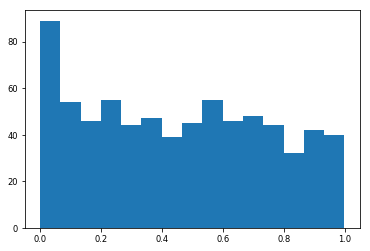

In [227]:
plt.hist(a.uns['scmemo']['1d_ht']['var_asl'], bins=15);

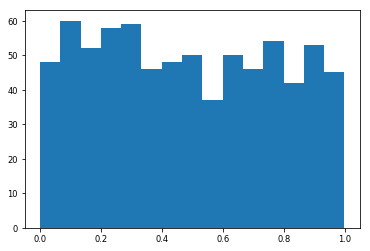

In [188]:
plt.hist(a.uns['scmemo']['1d_ht']['var_asl'], bins=15);

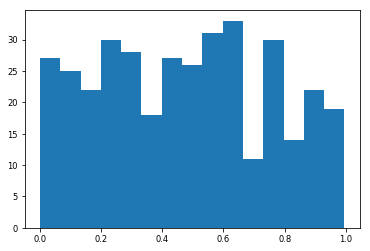

In [105]:
plt.hist(a.uns['scmemo']['1d_ht']['mean_asl'], bins=15);

## 

In [42]:
from sklearn.impute import SimpleImputer

In [44]:
a = np.array([1, 2, 3])

In [45]:
eval('a')

array([1, 2, 3])

In [534]:
imp.reload(hypothesis_test)
imp.reload(scmemo)
a = scmemo.ht_1d_moments(adata_scmemo, 'ct', inplace=False, use_residual_var=True)

In [535]:
a.uns['scmemo']['1d_ht']['design_matrix']

DesignMatrix with shape (2, 2)
  Intercept  ct[T.PBMC]
          1           1
          1           0
  Terms:
    'Intercept' (column 0)
    'ct' (column 1)

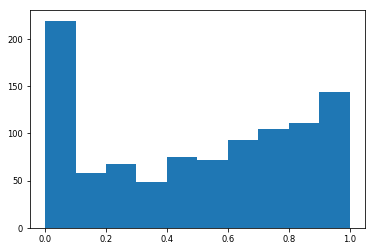

In [531]:
plt.hist(a.uns['scmemo']['1d_ht']['var_result'][2][1, :]);

In [491]:
%%time
# res_1 = scmemo.bootstrap_1d_moments(adata_scmemo, inplace=False, num_boot=100000, verbose=True, bins=1)
# res_2 = scmemo.bootstrap_1d_moments(adata_scmemo, inplace=False, num_boot=100000, verbose=True, bins=2)
res_3 = scmemo.bootstrap_1d_moments(adata_scmemo, inplace=False, num_boot=1000, verbose=True, bins=3)


sg^PBMC
CPU times: user 127 ms, sys: 60 ms, total: 186 ms
Wall time: 186 ms


In [463]:
from statsmodels.distributions.empirical_distribution import ECDF

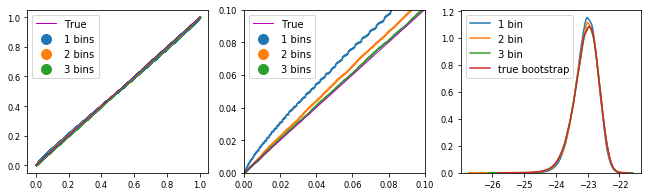

In [489]:
plt.figure(figsize=(11, 3))
plt.subplot(1, 3, 1)
plt.plot([-0,1], [-0,1], lw=1, color='m')
plt.scatter(
    ecdf.y[1:],
    ecdf(np.sort(np.log(res_1[1]))),
    s=0.01)
plt.scatter(
    ecdf.y[1:],
    ecdf(np.sort(np.log(res_2[1]))),
    s=0.01)
plt.scatter(
    ecdf.y[1:],
    ecdf(np.sort(np.log(res_3[1]))),
    s=0.01)
plt.legend(['True', '1 bins', '2 bins', '3 bins'], markerscale=100)

plt.subplot(1, 3, 2)
plt.plot([-0,1], [-0,1], lw=1, color='m')
plt.scatter(
    ecdf.y[1:],
    ecdf(np.sort(np.log(res_1[1]))),
    s=0.01)
plt.scatter(
    ecdf.y[1:],
    ecdf(np.sort(np.log(res_2[1]))),
    s=0.01)
plt.scatter(
    ecdf.y[1:],
    ecdf(np.sort(np.log(res_3[1]))),
    s=0.01)
plt.xlim(0, .1); plt.ylim(0, .1)
plt.legend(['True', '1 bins', '2 bins', '3 bins'], markerscale=100)

plt.subplot(1, 3, 3)
sns.distplot(np.log(res_1[1]), hist=False, label='1 bin')
sns.distplot(np.log(res_2[1]), hist=False, label='2 bin')
sns.distplot(np.log(res_3[1]), hist=False, label='3 bin')
sns.distplot(np.log(real_boot_vars), hist=False, label='true bootstrap')
